In [1]:
from src.foundation.engine import Engine
from src.data_handler.data_handler import DataHandler
from src.explainability.pdp import PDP
from datetime import datetime
import ipdb

Define hyper-parameters for DS data:

In [18]:
hyperparam_dict_ds_data = {
        'states': ['lead_time', 'length_of_stay',
                   'competitor_price_difference_bin', 'demand_bin'],
        'actions': ['price'],
        'bins': [10, 10, 4, 4, 10], #TODO: these correspond to the states and actions. Probably should change to a dict.
        'rewards': ['reward'],
        'feature_types': {
            'lead_time': "continuous",
            'length_of_stay': "continuous",
            'competitor_price_difference_bin': "discrete",
            'demand_bin': "discrete",
            'price': "continuous",
            'reward': "continuous"
        },
        'n_samples': 100000,
        'data_path': 'data/ds-data/my_example_data.parquet',
        'col_delimiter': '|',
        'cols_to_normalise': ['lead_time', 'length_of_stay',
                   'competitor_price_difference_bin', 'demand_bin', 'price', 'reward'],
        'agent_type': 'q_learner',
        'env_type': 'strategic_pricing',
        'num_episodes': 100000,
        'num_steps': 1,
        'train_test_split': 0.2
    }

hyperparam_dict = hyperparam_dict_ds_data

Train agent (I interrupted at 50,000 episodes because it was taking too long):

In [19]:
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"{timestamp}: Load data")
states = hyperparam_dict['states']
actions = hyperparam_dict['actions']
rewards = hyperparam_dict['rewards']
n_samples = hyperparam_dict['n_samples']
dh = DataHandler(data_path=hyperparam_dict['data_path'],
                    state_labels=states,
                    action_labels=actions,
                    reward_labels=rewards,
                    n_samples=n_samples)

# Preprocess the data
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"{timestamp}: Preprocess data")
dh.prepare_data_for_engine(col_delimiter=hyperparam_dict['col_delimiter'],
                            cols_to_normalise=hyperparam_dict[
                                'cols_to_normalise'])

# Create engine
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

print(f"{timestamp}: Initialize Engine")
engine = Engine(dh,
                agent_type=hyperparam_dict['agent_type'],
                env_type=hyperparam_dict['env_type'],
                num_episodes=hyperparam_dict['num_episodes'],
                num_steps=hyperparam_dict['num_steps'],
                bins=hyperparam_dict['bins'],
                train_test_split = hyperparam_dict['train_test_split']
                )
# Create world
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"{timestamp}: Create the world")
engine.create_world()

# Train agent
timestamp = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"{timestamp}: Train the agent on {n_samples} samples")
engine.train_agent(evaluate=True, n_eval_steps=1000)

13/04/2023 17:17:13: Load data
13/04/2023 17:17:13: Preprocess data
13/04/2023 17:17:18: Initialize Engine
13/04/2023 17:17:18: Create the world
Initialize environment
Create average rewards matrix
Initialize agent
13/04/2023 17:17:31: Train the agent on 100000 samples


100%|██████████| 1000/1000 [00:14<00:00, 71.06it/s]


KeyboardInterrupt: 

Evaluate agent (get evaluation states, actions, rewards, and recommended actions and resulting rewards):

In [38]:
states, actions, rewards_hist, actions_agent, rewards_agent = \
    engine.evaluate_agent()

# Sum obtained reward optimal vs historical policy
import numpy as np
print(f"Return based on historical data: {np.sum(rewards_hist)}")
print(f"Return based on agent policy: {np.sum(rewards_agent)}")

Return based on historical data: 148237.26894357443
Return based on agent policy: 203159.5945763065


Get plot of cumulative reward vs iteration:

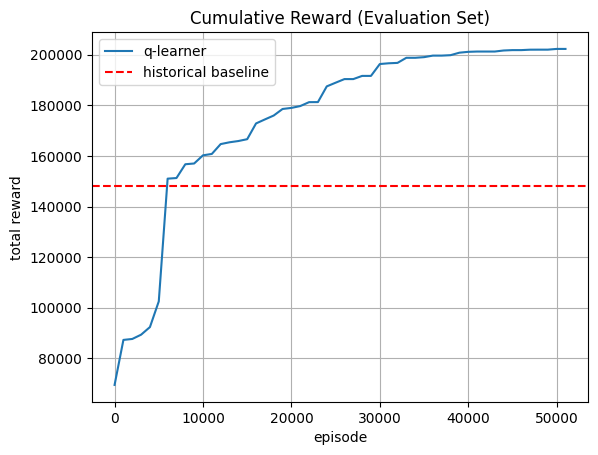

In [53]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
axes.plot([i*1000 for i in range(len(engine.agent_cumrewards))], engine.agent_cumrewards, label='q-learner')
axes.axhline(np.sum(rewards_hist), color='r',linestyle='--', label='historical baseline')
axes.grid()
axes.set_xlabel("episode")
axes.set_ylabel("total reward")
axes.legend()
axes.set_title("Cumulative Reward (Evaluation Set)")
plt.savefig("cumulative_reward.png")


Get plot of reward percentiles:

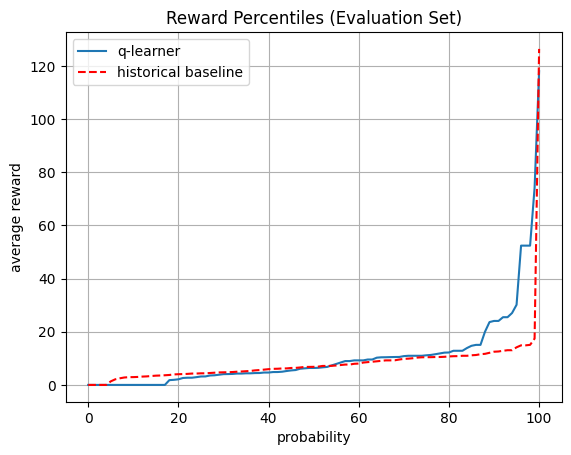

In [55]:
rewards_agent_array = np.array([r[0] for r in rewards_agent])
agent_percentiles = np.percentile(rewards_agent_array, q=np.linspace(0,100,101))

rewards_hist_array = np.array([r[0] for r in rewards_hist])
hist_percentiles = np.percentile(rewards_hist_array, q=np.linspace(0,100,101))

fig, axes = plt.subplots()
axes.plot(np.linspace(0,100,101), agent_percentiles, label='q-learner')
axes.plot(np.linspace(0,100,101), hist_percentiles, color='r',linestyle='--', label='historical baseline')

axes.grid()
axes.set_xlabel("probability")
axes.set_ylabel("average reward")
axes.legend()
axes.set_title("Reward Percentiles (Evaluation Set)")
plt.savefig("reward_percentiles.png")